# LifeSnaps Preprocessing Experiments

#### Import de llibreries necessaries

In [14]:
import warnings
warnings.filterwarnings('ignore')

# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
import joblib

# Hyperparameter tuning
import optuna
from xgboost import XGBClassifier

# Imbalanced data pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Core utilities
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# Preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Model definitions
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Model selection and evaluation
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    learning_curve
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    make_scorer,
    roc_auc_score,
)

from ai_health_assistant.utils.train_helpers import train_models, append_results, plot_learning_curve, mat_confusio


# Configuració de pandas
pd.set_option('display.max_columns', None)

# Carrega de dades
df = pd.read_csv('../data/df_preprocessed.csv')
print(f"Shape: {df.shape}")


Shape: (2290, 32)


## Lectura de dades i split de train / test

In [2]:
# Comprovem quina es les estructura de les nostres dades faltants en el target
TARGET = 'TIRED'

df_complete = df.dropna(subset=[TARGET])

df_null_targets = df[df["TIRED"].isnull()]

print(f"Estructura dades amb target:\n{df_complete.shape}")
print(f"Estructura dades target null:\n{df_null_targets.shape}")

Estructura dades amb target:
(2290, 32)
Estructura dades target null:
(0, 32)


In [3]:
# Difinim X i el target y
# Prediccio de TIRED
X = df_complete.drop(columns=[TARGET])
y = df_complete[TARGET]

numerical_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

print(f"\nCol. numeriques ({len(numerical_features)}): \n{numerical_features}")
print(f"Col. categoriques ({len(categorical_features)}): \n{categorical_features}")




Col. numeriques (31): 
['num__nightly_temperature', 'num__nremhr', 'num__rmssd', 'num__spo2', 'num__full_sleep_breathing_rate', 'num__stress_score', 'num__daily_temperature_variation', 'num__calories', 'num__bpm', 'num__sedentary_minutes', 'num__lightly_active_minutes', 'num__very_active_minutes', 'num__resting_hr', 'num__minutesAsleep', 'num__minutesAwake', 'num__sleep_efficiency', 'num__sleep_deep_ratio', 'num__sleep_wake_ratio', 'num__sleep_light_ratio', 'num__sleep_rem_ratio', 'num__steps', 'num__bmi', 'num__wake_after_sleep_pct', 'cat__age_<30', 'cat__age_>=30', 'cat__gender_FEMALE', 'cat__gender_MALE', 'cat__bmi_tipo_Infrapes', 'cat__bmi_tipo_Normal', 'cat__bmi_tipo_Obes', 'cat__bmi_tipo_Sobrepes']
Col. categoriques (0): 
[]


### Train / Test Split

In [4]:
# Estratifiquem respecte un dels targets per tal d'assegurar el bon split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print('\n','--'*50)
print(f"\nDistribució train:\n{y_train.value_counts(normalize=True)}")
print(f"\nDistribució test:\n{y_test.value_counts(normalize=True)}")



Train shape: (1832, 31)
Test shape: (458, 31)

 ----------------------------------------------------------------------------------------------------

Distribució train:
TIRED
0.0    0.615721
1.0    0.384279
Name: proportion, dtype: float64

Distribució test:
TIRED
0.0    0.615721
1.0    0.384279
Name: proportion, dtype: float64


### Classifiers i Grids que utilitzarem

Anem modificant tant els hiperparametres com els classifiers per tal d'anar ajustant el overfitting que hem detectat que tenim

In [35]:
CLASSIFIERS = {
    # Early stopping i més iteracions però amb atur automàtic
    "MLP": MLPClassifier(
        random_state=42,
        max_iter=500,
        early_stopping=True,       # valida internament al 10 %
        validation_fraction=0.1,
        n_iter_no_change=20
    ),

    # SVM amb kernels diversos, class_weight ja inclòs al grid
    "SVM": SVC(
        random_state=42,
        probability=True
    ),

    # RandomForest
    "RandomForest": RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ),

    # GradientBoosting amb subsampling
    "GradientBoosting": GradientBoostingClassifier(
        random_state=42
    )
}

# Grids ampliats (més regularització)
PARAM_GRIDS = {

    "MLP": {
        "classifier__hidden_layer_sizes": [(32,), (32, 16), (64, 32)],
        "classifier__alpha": uniform(1e-3, 1e-1),
        "classifier__learning_rate_init": uniform(0.001, 0.009),
        "classifier__batch_size": [64, 128]
    },

    "SVM": {
        "classifier__C": uniform(0.01, 10),
        "classifier__kernel": ["linear", "rbf"],
        "classifier__gamma": ["scale", "auto"],
        "classifier__class_weight": ["balanced"]
    },

    "RandomForest": {
        "classifier__n_estimators": randint(400, 600),
        "classifier__max_depth":    randint(5, 7),
        "classifier__min_samples_split": randint(1, 8),
        "classifier__min_samples_leaf":  randint(1, 3),
        "classifier__max_features": ["sqrt", "log2", 0.25],   # fracció features
        "classifier__class_weight": ["balanced", "balanced_subsample"]
    },

    "GradientBoosting": {
        "classifier__n_estimators": randint(400, 1000),
        "classifier__learning_rate": uniform(0.01, 0.09),  # 0.01−0.10
        "classifier__max_depth": randint(2, 4),
        "classifier__subsample": uniform(0.6, 0.4),        # 0.6−1.0
        "classifier__min_samples_leaf": randint(2, 8)
    }
}

## ENTRENAMENT DEL MODEL BASE

In [ ]:
# # Provarem de apuntar al accuracy o al f1 score de la classe 1, 
# f1_cls1 = make_scorer(f1_score, pos_label=1)
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

display_cols = ['Target', 'Experiment',	'Model', 'Train F1 (1)', 'Test F1 (1)',	'Train F1 (macro global)', 'Test F1 (macro global)', 'Train Accuracy', 'Test Accuracy']



#### Filtre de prova amb alguns models

In [33]:
# Proves amb els models
PROVA_MODELS = ["RandomForest", "MLP"]

# Filtre per no haver de entrenar tots el models
CLASSIFIERS_FILTER = {k: v for k, v in CLASSIFIERS.items() if k in PROVA_MODELS}

### Regressió Logistica


Train F1 (1): 0.5185 | Test F1 (1): 0.5347 | Train Acc: 0.5955 | Test Acc: 0.6048
              precision    recall  f1-score   support

         0.0     0.7061    0.6135    0.6565       282
         1.0     0.4883    0.5909    0.5347       176

    accuracy                         0.6048       458
   macro avg     0.5972    0.6022    0.5956       458
weighted avg     0.6224    0.6048    0.6097       458



,Target,Experiment,Model,Train F1 (1),Test F1 (1),Train F1 (macro global),Test F1 (macro global),Train Accuracy,Test Accuracy
0,TIRED,Entrenament basic,Logistic Regression,0.5185,0.5347,0.5849,0.5956,0.5955,0.6048


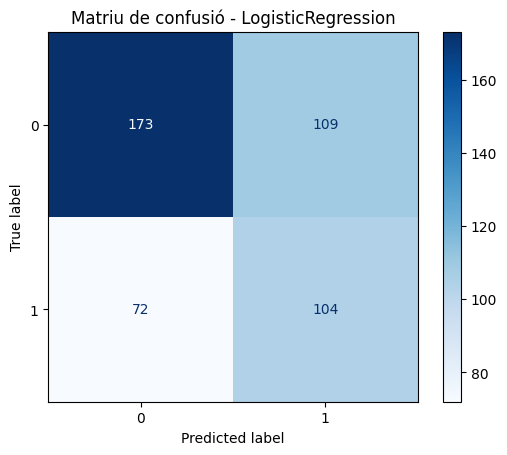

In [8]:

reg_results = []
reg_models = {}

reg_pipeline = Pipeline(steps=[
    ("classifier", LogisticRegression(
        max_iter=2000,            # convergència assegurada
        class_weight="balanced", # tracta l’imbalance de la classe 1
        solver="lbfgs",          # ràpid i estable per datasets petits/mitjans
    ))
])

reg_param_grid = {
    "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100, 200, 500, 1000]
}

best_est, y_train_pred, train_report, y_test_pred, test_report, best_params, best_score = train_models(
        X_train, 
        y_train,
        X_test,
        y_test, 
        reg_pipeline, 
        reg_param_grid,
        search_type='grid'
    )

reg_models["Logistic Regression"] = best_est

reg_results_df = append_results(
    reg_results,
    "Logistic Regression",
    train_report,
    test_report,
    best_params,
    best_score,
    experiment="Entrenament basic"
)

display(reg_results_df[display_cols].round(4))

mat_confusio(
    "LogisticRegression",
    y_test,
    y_test_pred
    )

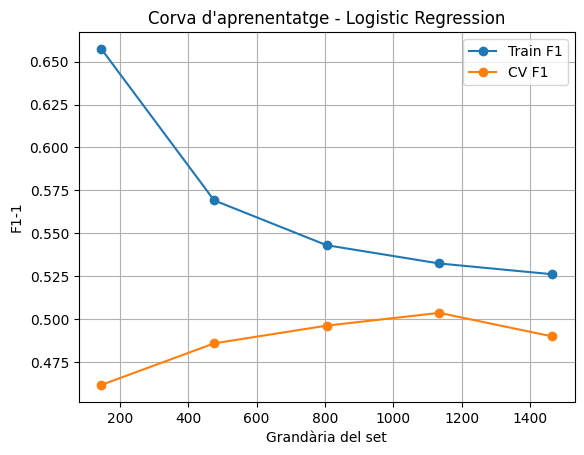

In [9]:
plot_learning_curve(
    "Logistic Regression",
    reg_models, 
    X_train, 
    y_train
    )

In [ ]:
base_results = []
base_models = {}

for model, classifier in CLASSIFIERS_FILTER.items():
    pipeline = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("classifier", classifier)
    ])

    print(f"\n==== {model} ====")
    best_est, y_train_pred, train_report, y_test_pred, test_report, best_params, best_score = train_models(
        X_train,
        y_train,
        X_test,
        y_test, 
        pipeline,
        PARAM_GRIDS[model]
    )

    base_models[model] = best_est

    base_results_df = append_results(
    base_results,
    model,
    train_report,
    test_report,
    best_params,
    best_score,
    experiment="Entrenament basic"
)


==== MLP ====

Train F1 (1): 0.5986 | Test F1 (1): 0.5490 | Train Acc: 0.6479 | Test Acc: 0.5983
              precision    recall  f1-score   support

         0.0     0.7168    0.5745    0.6378       282
         1.0     0.4828    0.6364    0.5490       176

    accuracy                         0.5983       458
   macro avg     0.5998    0.6054    0.5934       458
weighted avg     0.6269    0.5983    0.6037       458


==== RandomForest ====

Train F1 (1): 0.6103 | Test F1 (1): 0.5197 | Train Acc: 0.6856 | Test Acc: 0.6004
              precision    recall  f1-score   support

         0.0     0.6957    0.6241    0.6579       282
         1.0     0.4829    0.5625    0.5197       176

    accuracy                         0.6004       458
   macro avg     0.5893    0.5933    0.5888       458
weighted avg     0.6139    0.6004    0.6048       458



In [11]:
display(base_results_df[display_cols].round(4))


,Target,Experiment,Model,Train F1 (1),Test F1 (1),Train F1 (macro global),Test F1 (macro global),Train Accuracy,Test Accuracy
0,TIRED,Entrenament basic,MLP,0.5986,0.5490,0.6425,0.5934,0.6479,0.5983
1,TIRED,Entrenament basic,RandomForest,0.6103,0.5197,0.6734,0.5888,0.6856,0.6004


In [15]:
print(base_results_df[base_results_df['Model'] == "RandomForest"]['Best Params'].values[0])

{'classifier__class_weight': 'balanced_subsample', 'classifier__max_depth': 4, 'classifier__max_features': np.float64(0.43559419734887395), 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 765}


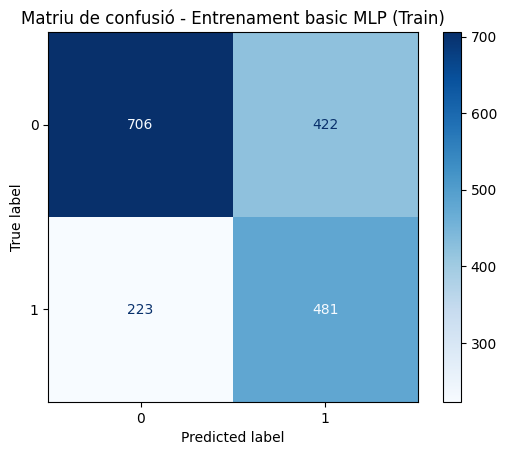

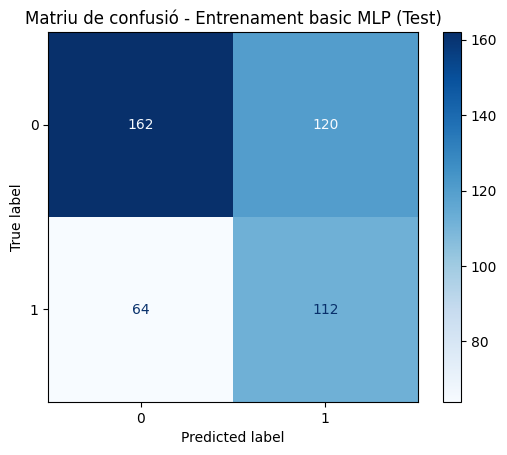

In [16]:
# El model que vulguem inspecciona
model_name = "MLP" # RandomForest, MLP, GradientBoosting, SVM
csf = base_models[model_name]


# Visualització del train
y_train_pred = csf.predict(X_train)

mat_confusio(
    f'Entrenament basic {model_name} (Train)',
    y_train,
    y_train_pred
)

# Visualització del test
y_test_pred = csf.predict(X_test)

mat_confusio(
    f"Entrenament basic {model_name} (Test)",
    y_test,
    y_test_pred
)

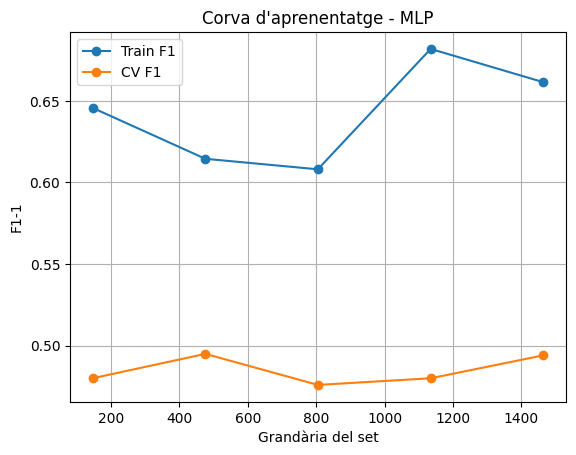

In [20]:
# Observem la corba d'aprenentatge:

plot_learning_curve(
    model_name,
    base_models,
    X_train,
    y_train
)

## EXPERIMENT 1: Importancia de les caracteristiques

Entrenem RandomForest per indentificar les caracteristiques més importants (10-15), posteriorment entrenem els models utilitzant aquestes 10-15 característiques, per veure si augmenta el rendiment del model. Proavarem tambe amb permutation importances.

### Feature Importance

La Gini importance d’una feature és: La suma de totes les reduccions d’impuresa (Gini) que ha causat al llarg de tots els arbres i de totes les seves aparicions.


Train F1 (1): 0.9079 | Test F1 (1): 0.4901 | Train Acc: 0.9307 | Test Acc: 0.6638
              precision    recall  f1-score   support

         0.0     0.6928    0.8156    0.7492       282
         1.0     0.5873    0.4205    0.4901       176

    accuracy                         0.6638       458
   macro avg     0.6400    0.6180    0.6196       458
weighted avg     0.6522    0.6638    0.6496       458

Top-10 features: ['num__calories', 'num__resting_hr', 'num__lightly_active_minutes', 'num__bpm', 'num__minutesAsleep', 'num__steps', 'num__daily_temperature_variation', 'num__sedentary_minutes', 'num__nightly_temperature', 'num__very_active_minutes']
Top-15 features: ['num__calories', 'num__resting_hr', 'num__lightly_active_minutes', 'num__bpm', 'num__minutesAsleep', 'num__steps', 'num__daily_temperature_variation', 'num__sedentary_minutes', 'num__nightly_temperature', 'num__very_active_minutes', 'num__bmi', 'num__sleep_efficiency', 'num__minutesAwake', 'num__wake_after_sleep_pct', '

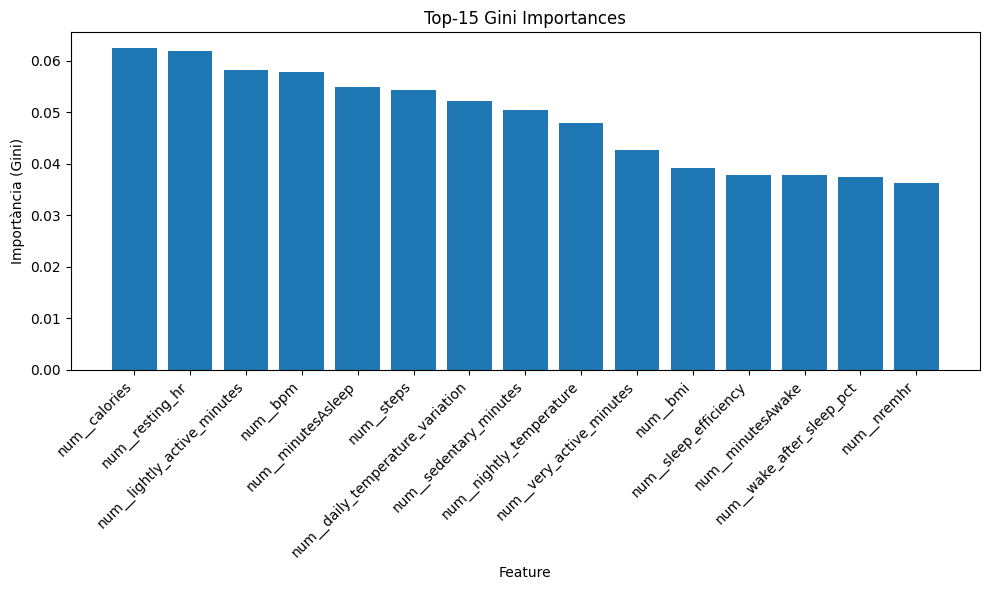

In [21]:
# Param grid & pipeline bàsic de random forest

param_grid_rf = {
    "clf__n_estimators":      [100, 200, 300],
    "clf__max_depth":         [None, 15, 30],
    "clf__min_samples_split": [2, 4, 8],
    "clf__min_samples_leaf":  [1, 2, 4]
}

pipe_rf = ImbPipeline([
    ("clf", RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1))
])

# Entrenament del model
best_est, y_train_pred, train_report, y_test_pred, test_report, best_params, best_score = train_models(
        X_train, 
        y_train,
        X_test,
        y_test, 
        pipe_rf, 
        param_grid_rf,
        search_type='grid'
    )


all_features = X_train.columns.tolist()

# Importàncies Gini i agregació per feature “base”
importances_raw = pd.Series(best_est.named_steps["clf"].feature_importances_,index=all_features)

def base_name(feat):
    if feat.startswith("cat__") and "_" in feat[6:]:
        return feat.rsplit("_", 1)[0]
    return feat

agg_importances = (
    importances_raw.groupby(base_name).sum().sort_values(ascending=False)
)


# Top-10 i Top-15 importàncies

top10 = agg_importances.head(10).index.tolist()
top15 = agg_importances.head(15).index.tolist()
print("Top-10 features:", top10)
print("Top-15 features:", top15)


# Visualització de les Top-15 importàncies
plt.figure(figsize=(10, 6))
plt.bar(agg_importances.head(15).index, agg_importances.head(15).values)
plt.xticks(rotation=45, ha="right")
plt.title("Top-15 Gini Importances")
plt.xlabel("Feature")
plt.ylabel("Importància (Gini)")
plt.tight_layout()
plt.show()


### Rentrenament de models 10-15 millors features

In [ ]:
# Definim els dos conjunts de features
feature_sets = {
    "Top10": top10,   # llista de 10 noms de feature “base”
    "Top15": top15    # llista de 15 noms de feature “base”
}

# Reentrenament i avaluació per a cada subset
fi_results = []
fi_models = {}

for label, feats in feature_sets.items():
    print(f"\nEntrenament models amb {label}")
    num_feats = [f for f in feats if f in numerical_features]
    cat_feats = [f for f in feats if f in categorical_features]

    for model, classifier in CLASSIFIERS_FILTER.items():

        print(f'==== {model} ====')
        pipe = ImbPipeline([
            ("smote", SMOTE(random_state=42)),
            ("classifier", classifier)
        ])


        best_est, y_train_pred, train_report, y_test_pred, test_report, best_params, best_score = train_models(
            X_train[feats],
            y_train,
            X_test[feats],
            y_test,
            pipe,
            PARAM_GRIDS[model]
        )

        fi_models[f"{model}_{label}"] = best_est

        append_results(
            fi_results,
            model,
            train_report,
            test_report,
            best_params,
            best_score,
            experiment=f"FI_{label}"
        )

Entrenament models amb Top10
==== MLP ====

Train F1 (1): 0.5426 | Test F1 (1): 0.4962 | Train Acc: 0.5868 | Test Acc: 0.5699
              precision    recall  f1-score   support

         0.0     0.6749    0.5816    0.6248       282
         1.0     0.4512    0.5511    0.4962       176

    accuracy                         0.5699       458
   macro avg     0.5630    0.5663    0.5605       458
weighted avg     0.5889    0.5699    0.5753       458

==== RandomForest ====

Train F1 (1): 0.7069 | Test F1 (1): 0.4869 | Train Acc: 0.7505 | Test Acc: 0.5721
              precision    recall  f1-score   support

         0.0     0.6706    0.5993    0.6330       282
         1.0     0.4515    0.5284    0.4869       176

    accuracy                         0.5721       458
   macro avg     0.5610    0.5638    0.5599       458
weighted avg     0.5864    0.5721    0.5768       458

Entrenament models amb Top15
==== MLP ====

Train F1 (1): 0.5886 | Test F1 (1): 0.5361 | Train Acc: 0.6070 | Test 

In [27]:
feature_importance_results_df = pd.DataFrame(fi_results)

display(feature_importance_results_df[display_cols].round(4))

,Target,Experiment,Model,Train F1 (1),Test F1 (1),Train F1 (macro global),Test F1 (macro global),Train Accuracy,Test Accuracy
0,TIRED,FI_Top10,MLP,0.5426,0.4962,0.5829,0.5605,0.5868,0.5699
1,TIRED,FI_Top10,RandomForest,0.7069,0.4869,0.7449,0.5599,0.7505,0.5721
2,TIRED,FI_Top15,MLP,0.5886,0.5361,0.6062,0.5638,0.6070,0.5655
3,TIRED,FI_Top15,RandomForest,0.5557,0.5094,0.5804,0.5433,0.5819,0.5459


### Permutation Importance

Per avaluar la importància de les característiques del model. Serveix per determinar quines característiques tenen més impacte en el rendiment del model.


Top-15 features (Permutation):


,Importancia
num__bmi,0.063788
cat__bmi_tipo_Sobrepes,0.030590
num__sleep_deep_ratio,0.010513
num__daily_temperature_variation,0.010098
cat__bmi_tipo_Normal,0.007959
cat__gender_FEMALE,0.007140
num__minutesAsleep,0.006386
num__full_sleep_breathing_rate,0.005011
num__rmssd,0.004945
cat__gender_MALE,0.004913


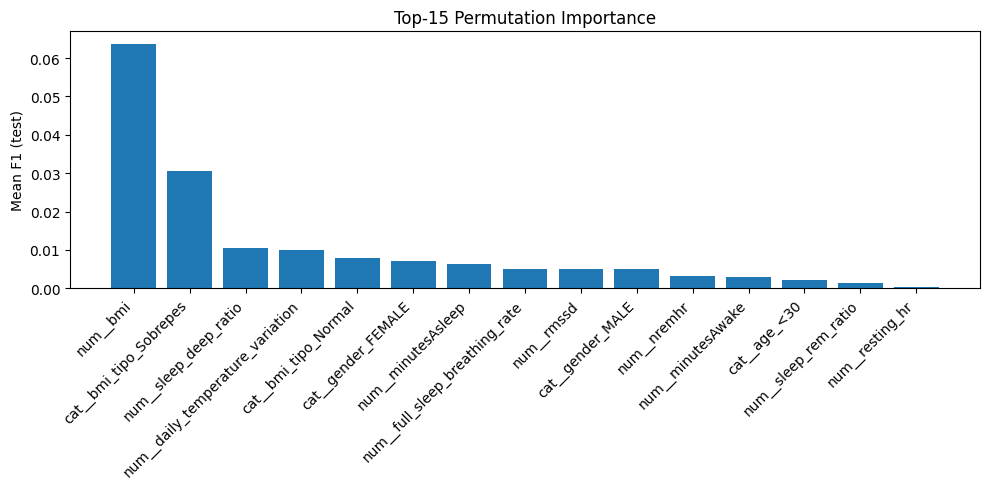

In [30]:
# Calcular permutation importance
best_rf_model=base_models["RandomForest"]
result = permutation_importance(
    best_rf_model,      # el teu model entrenat per al sol target
    X_test, 
    y_test,
    n_repeats=200,
    n_jobs=-1,
    random_state=42
)



perm_importances = (
    pd.Series(result.importances_mean, index=all_features).sort_values(ascending=False)
)


# Extreure Top-10 i Top-15
perm_top_features = {
    10: perm_importances.head(10).index.tolist(),
    15: perm_importances.head(15).index.tolist()
}


# Mostrem la taula i la gràfica  de Top-15

print("\nTop-15 features (Permutation):")
display(perm_importances.head(15).to_frame("Importancia"))


plt.figure(figsize=(10, 5))
top15 = perm_importances.head(15)
plt.bar(top15.index, top15.values)
plt.title("Top-15 Permutation Importance")
plt.ylabel("Mean F1 (test)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Reentrenament Permutation importance

In [34]:

# Resultats i models per a Top-k
perm_results = []
perm_models  = {}

for k in [10, 15]:
    sel_feats = perm_top_features[k]

    for model, classifier in CLASSIFIERS_FILTER.items():
        pipe = ImbPipeline([
            ("smote",        BorderlineSMOTE(random_state=42, sampling_strategy=0.95)),
            ("classifier",   classifier)
        ])

        best_est, y_train_pred, train_report, y_test_pred, test_report, best_params, best_score = train_models( 
            X_train[sel_feats], 
            y_train,
            X_test[sel_feats],
            y_test, 
            pipe, 
            PARAM_GRIDS[model]
        )
        
        perm_models[f'{model}_Top{k}'] = best_est
      
        append_results(
            perm_results,
            model,
            train_report,
            test_report,
            best_params,
            best_score,
            experiment= f"Perm_Top{k}"
        )


Train F1 (1): 0.6065 | Test F1 (1): 0.4789 | Train Acc: 0.6692 | Test Acc: 0.5677
              precision    recall  f1-score   support

         0.0     0.6654    0.5993    0.6306       282
         1.0     0.4461    0.5170    0.4789       176

    accuracy                         0.5677       458
   macro avg     0.5557    0.5582    0.5548       458
weighted avg     0.5811    0.5677    0.5723       458


Train F1 (1): 0.5584 | Test F1 (1): 0.5000 | Train Acc: 0.5890 | Test Acc: 0.5415
              precision    recall  f1-score   support

         0.0     0.6682    0.5071    0.5766       282
         1.0     0.4303    0.5966    0.5000       176

    accuracy                         0.5415       458
   macro avg     0.5493    0.5518    0.5383       458
weighted avg     0.5768    0.5415    0.5472       458


Train F1 (1): 0.6465 | Test F1 (1): 0.5393 | Train Acc: 0.7003 | Test Acc: 0.6157
              precision    recall  f1-score   support

         0.0     0.7103    0.6348    0.670

In [32]:
perm_topk_results_df = pd.DataFrame(perm_results)
display(perm_topk_results_df[display_cols].round(4))

,Target,Experiment,Model,Train F1 (1),Test F1 (1),Train F1 (macro global),Test F1 (macro global),Train Accuracy,Test Accuracy
0,TIRED,Perm_Top10,MLP,0.6065,0.4789,0.6606,0.5548,0.6692,0.5677
1,TIRED,Perm_Top10,SVM,0.5598,0.5224,0.6098,0.5744,0.6163,0.5808
2,TIRED,Perm_Top10,RandomForest,0.5584,0.5000,0.5870,0.5383,0.5890,0.5415
3,TIRED,Perm_Top10,GradientBoosting,0.8559,0.4593,0.8847,0.5671,0.8919,0.5939


## EXPERIMENT 2: PCA


Es realitza una anàlisi de components principals (PCA) per examinar com evolucionen els components més rellevants del conjunt de dades en termes de variància explicada acumulada, considerant els primers 5, 10, 15, 20 i 25 components

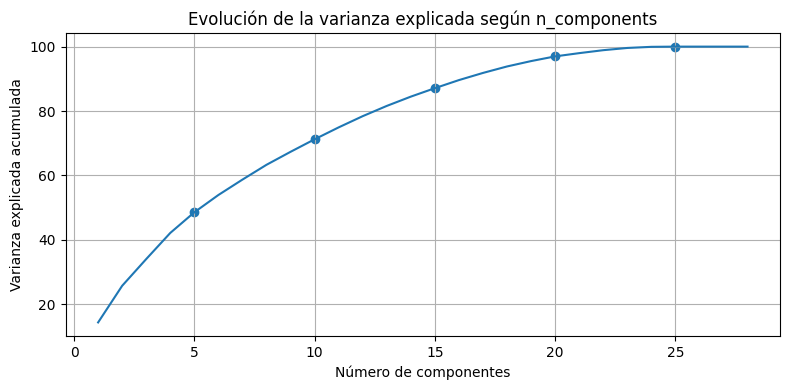

In [ ]:
pca = PCA(random_state=42)
pca.fit(X_train)

# 3) Calcular la varianza explicada acumulada
explained_cumsum = pca.explained_variance_ratio_.cumsum()*100

# 4) Definir los puntos de interés y extraer sus valores
ks = [5, 10, 15, 20, 25]
cums = explained_cumsum[[k-1 for k in ks]]

# 5) Dibujar la curva completa y señalar los ks elegidos
plt.figure(figsize=(8, 4))
plt.plot(
    range(1, len(explained_cumsum) + 1),
    explained_cumsum,
)
plt.scatter(ks, cums)
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Evolución de la varianza explicada según n_components')
plt.grid(True)
plt.tight_layout()
plt.show()

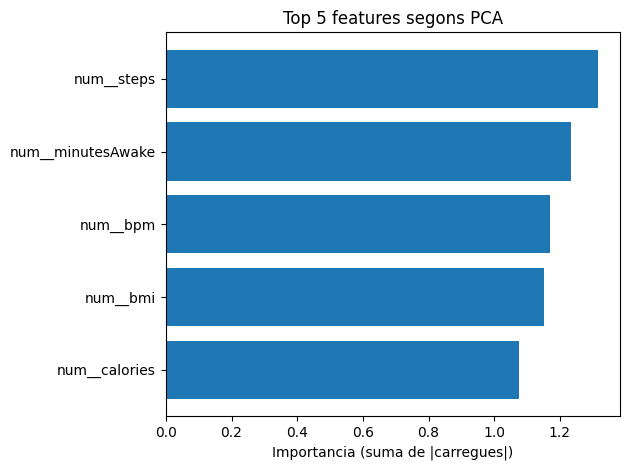

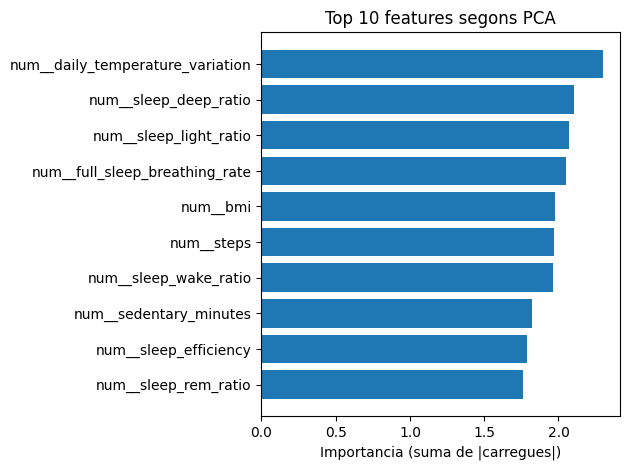

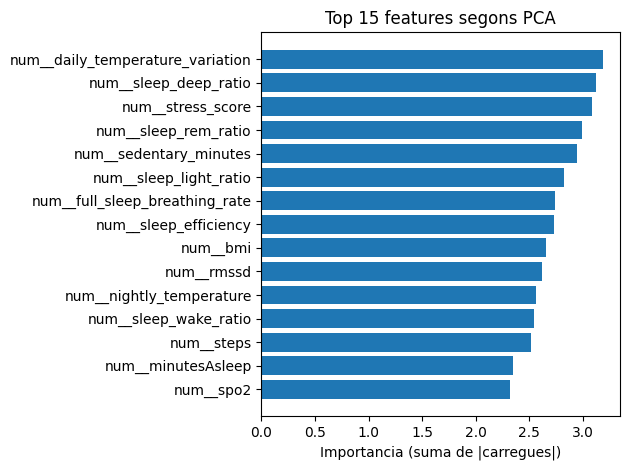

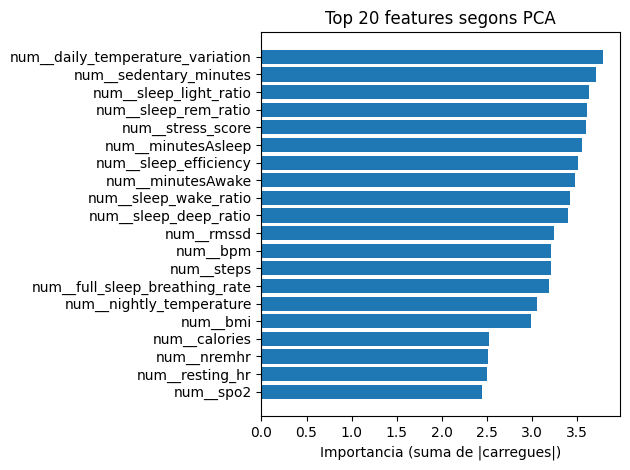

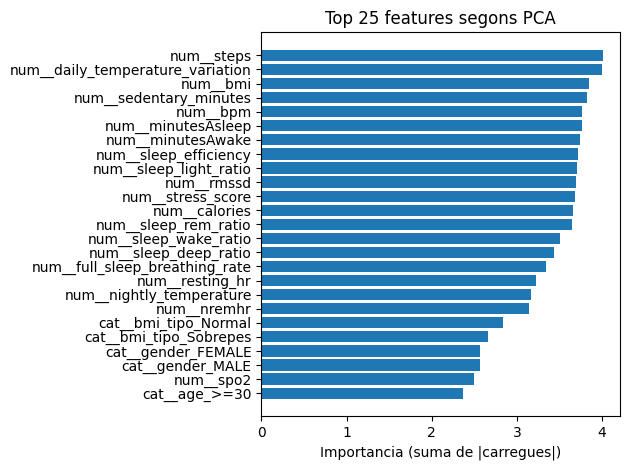

In [ ]:
n_components_list = [5, 10, 15, 20, 25]
for k in n_components_list:
    # Ajusta PCA
    pca = PCA(n_components=k, random_state=42)
    pca.fit(X_train)

    # loadings: matriz (n_features, k)
    loadings = pca.components_.T

    # importancia = suma de cargas absolutes de cada feature en tots els components
    importance = np.sum(np.abs(loadings), axis=1)

    # crea DataFrame, ordena top-k
    df_imp = pd.DataFrame({
        'feature':    all_features,
        'importance': importance
    }).sort_values('importance', ascending=False).reset_index(drop=True)
    topk = df_imp.head(k)

    plt.figure()
    plt.barh(topk['feature'][::-1], topk['importance'][::-1])
    plt.xlabel('Importancia (suma de |carregues|)')
    plt.title(f'Top {k} features segons PCA')
    plt.tight_layout()
    plt.show()

Aquests gràfics mostren, per cada valor de *k* (5, 10, 15, 20 i 25 components), quines variables original s’aporten més a l’espai de la PCA i, per tant, expliquen més variància del conjunt de dades.

* **Components principals**: són noves variables creades com a combinacions lineals de les variables originals.
* **Càrregues (loadings)**: cada component té un coeficient per a cada variable; aquell coeficient indica quant “pesa” la variable en aquest eix.
* **Importància de la variable**: per a cada variable, sumem el valor absolut de les càrregues als primers *k* components. Una suma més alta vol dir que la variable contribueix de manera rellevant a la variació capturada per aquests *k* eixos.

Així podem veure quines són les *k* variables que més pesen ens diu quins atributs són més informatius (i quins, en canvi, aporten informació redundant).
Els tops *k* ajuden a identificar les característiques més representatives del dataset segons la PCA.


In [ ]:
# Guarda resultats i models
pca_results = []
pca_models = {}


for k in n_components_list:
    print(f"\n-- PCA - {k} components --")

    for model, classifier in CLASSIFIERS.items():
        # Pipeline amb preprocessor, SMOTE, PCA i classificador
        pipeline = ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote",        SMOTE(random_state=42)),
            ("pca",          PCA(n_components=k, random_state=42)),
            ("classifier",   classifier)
        ])

        best_est, y_pred, report, best_params, best_score = train_models( 
        X_train, 
        y_train, 
        pipeline, 
        PARAM_GRIDS[model]
        )

        # Guarda el millor model
        pca_models[f'{model}_PCA{k}'] = best_est

        append_results(
            pca_results,
            f"PCA_{k}",
            model,
            y_pred,
            report,
            best_params,
            best_score
        )



-- PCA - 5 components --


KeyboardInterrupt: 

In [ ]:
pca_results_df = pd.DataFrame(pca_results)
display(pca_results_df[display_cols].round(4))

,Target,Experiment,Model,Best CV,Test F1 (1),Test F1 (macro global),Test Accuracy
0,TIRED,PCA_5,MLP,0.4808,0.4675,0.5407,0.5524
1,TIRED,PCA_5,SVM,0.5009,0.5290,0.5552,0.5568
2,TIRED,PCA_5,RandomForest,0.4717,0.4132,0.5140,0.5349
3,TIRED,PCA_5,GradientBoosting,0.4740,0.4348,0.5276,0.5459
4,TIRED,PCA_10,MLP,0.4854,0.4959,0.5825,0.6004
5,TIRED,PCA_10,SVM,0.4921,0.5041,0.5848,0.6004
6,TIRED,PCA_10,RandomForest,0.4789,0.5056,0.5927,0.6114
7,TIRED,PCA_10,GradientBoosting,0.4803,0.4294,0.5350,0.5590
8,TIRED,PCA_15,MLP,0.4713,0.4944,0.5836,0.6026
9,TIRED,PCA_15,SVM,0.4833,0.5027,0.5798,0.5939


## EXPERIMENT 3: KNN Imputation

In [ ]:

# 1) Transformers amb KNN per a numèriques i categòriques
knn_numeric_transformer = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler",  StandardScaler())
])

knn_categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor_knn = ColumnTransformer([
    ("num", knn_numeric_transformer, numerical_features),
    ("cat", knn_categorical_transformer, categorical_features)
], remainder="drop")

# 2) Entrenament amb KNN Imputation
knn_results = []                
knn_models  = {}                    

    
for model_name, classifier in CLASSIFIERS.items():
    pipe = ImbPipeline([
        ("preprocessor", preprocessor_knn),
        ("smote",        SMOTE(random_state=42)),
        ("classifier",   classifier)
    ])
    
    gs = GridSearchCV(
        pipe,
        PARAM_GRIDS[model_name],
        scoring=f1_cls1,
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train, y_train)
    
    best_est = gs.best_estimator_
    knn_models[model_name] = best_est
    
    y_pred = best_est.predict(X_test)
    report = classification_report(
        y_test, y_pred,
        labels=[0, 1],
        output_dict=True,
        zero_division=0
    )
    
    knn_results.append({
        "Target":                TARGET,
        "Experiment":            "KNN_Imputation",
        "Model":                 model_name,
        "Best Params":           gs.best_params_,
        "Best CV":               gs.best_score_,
        "Test Precision (1)":    report["1"]["precision"],
        "Test Recall (1)":       report["1"]["recall"],
        "Test F1 (1)":           report["1"]["f1-score"],
        "Test F1 (macro global)": f1_score(y_test, y_pred, average="macro"),
        "Test Accuracy":         report["accuracy"],
    })
    
    print(f"{model_name:20s} | Best CV: {gs.best_score_:.4f} | Test F1(cl1): {report['1']['f1-score']:.4f} | Acc: {report["accuracy"]:.4f}")


MLP                  | Best CV: 0.4669 | Test F1(cl1): 0.5013 | Acc: 0.5961
SVM                  | Best CV: 0.4882 | Test F1(cl1): 0.5296 | Acc: 0.6004
RandomForest         | Best CV: 0.4807 | Test F1(cl1): 0.4970 | Acc: 0.6288
GradientBoosting     | Best CV: 0.4752 | Test F1(cl1): 0.4812 | Acc: 0.6092


In [ ]:
# 3) DataFrame resum
knn_df = pd.DataFrame(knn_results)

display(knn_df[display_cols].round(4))

NameError: name 'knn_results' is not defined

## EXPERIMENT 4: Target Row augmententation

In [ ]:
# ------------------------------------------------------------------
# 0) Preparació de les dades amb missings pel sol target
# ------------------------------------------------------------------
df_missing = df_null_targets.copy()
X_missing = df_missing.drop(columns=[TARGET])
print("Shape of features with missing target:", X_missing.shape)

# ------------------------------------------------------------------
# 1) Generació de pseudo-labels amb el millor model KNN
# ------------------------------------------------------------------
print(f"\nGenerant pseudo-labels per a {TARGET} …")
best_knn_row = (
    knn_df.sort_values("Test Accuracy", ascending=False).head(1)
)

best_knn_model_name = best_knn_row["Model"].iloc[0]
best_knn_model = knn_models[best_knn_model_name]
pseudo_labels = best_knn_model.predict(X_missing)
print(f"  {len(pseudo_labels)} pseudo-labels generades amb {best_knn_model_name}")

# ------------------------------------------------------------------
# 2) Concatena dades originals + pseudo-labels i prepara re-entrenament
# ------------------------------------------------------------------
X_train_aug = pd.concat([X_train, X_missing], ignore_index=True)
y_train_aug = pd.concat([y_train, pd.Series(pseudo_labels)], ignore_index=True)
print("Train augmentat:", X_train_aug.shape)

# ------------------------------------------------------------------
# 3) Retraining sobre dades augmentades
# ------------------------------------------------------------------
target_aug_results = []
target_aug_models  = {}

for model_name, clf in CLASSIFIERS.items():
    print(f"\n=== Retraining · {model_name} sobre dades augmentades ===")
    pipe = ImbPipeline([
        ("preprocessor", preprocessor_knn),  # mateix imputador KNN + OHE
        ("smote",        SMOTE(random_state=42)),
        ("classifier",   clf)
    ])

    gs = GridSearchCV(
        pipe,
        PARAM_GRIDS[model_name],
        scoring=f1_cls1,
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train_aug, y_train_aug)

    best_est = gs.best_estimator_
    target_aug_models[model_name] = best_est

    y_pred    = best_est.predict(X_test)
    report    = classification_report(
        y_test, y_pred,
        labels=[0, 1],
        output_dict=True,
        zero_division=0
    )
    macro_f1  = f1_score(y_test, y_pred, average="macro")
    test_acc  = report["accuracy"]

    target_aug_results.append({
        "Target":                TARGET,
        "Experiment":            "Target_Augmentation",
        "Model":                 model_name,
        "Best Params":           gs.best_params_,
        "Best CV":               gs.best_score_,
        "Test Precision (1)":    report["1"]["precision"],
        "Test Recall (1)":       report["1"]["recall"],
        "Test F1 (1)":           report["1"]["f1-score"],
        "Test F1 (macro global)": macro_f1,
        "Test Accuracy":         test_acc,
    })

    print(f"{model_name:20s} | Best CV: {gs.best_score_:.4f} | Test F1(cl1): {report['1']['f1-score']:.4f} | Acc: {test_acc:.4f}")


Shape of features with missing target: (5120, 23)

Generant pseudo-labels per a TIRED …
  5120 pseudo-labels generades amb RandomForest
Train augmentat: (6952, 24)

=== Retraining · MLP sobre dades augmentades ===
MLP                  | Best CV: 0.7121 | Test F1(cl1): 0.5165 | Acc: 0.6157

=== Retraining · SVM sobre dades augmentades ===
SVM                  | Best CV: 0.7288 | Test F1(cl1): 0.5102 | Acc: 0.5808

=== Retraining · RandomForest sobre dades augmentades ===
RandomForest         | Best CV: 0.7507 | Test F1(cl1): 0.4866 | Acc: 0.6223

=== Retraining · GradientBoosting sobre dades augmentades ===
GradientBoosting     | Best CV: 0.7401 | Test F1(cl1): 0.4458 | Acc: 0.5983


In [ ]:
# ------------------------------------------------------------------
# 3) DataFrame resum final
# ------------------------------------------------------------------
aug_df = pd.DataFrame(target_aug_results)
display(aug_df[display_cols].round(4))



,Target,Experiment,Model,Best CV,Test F1 (1),Test F1 (macro global),Test Accuracy
0,TIRED,Target_Augmentation,MLP,0.7121,0.5165,0.5988,0.6157
1,TIRED,Target_Augmentation,SVM,0.7288,0.5102,0.5719,0.5808
2,TIRED,Target_Augmentation,RandomForest,0.7507,0.4866,0.5939,0.6223
3,TIRED,Target_Augmentation,GradientBoosting,0.7401,0.4458,0.5654,0.5983


## Anàlisi de resultats

In [ ]:
# --- Results Compilation ---
all_results_dfs = [base_results_df]
if 'feature_importance_results_df' in locals() and not feature_importance_results_df.empty: 
    all_results_dfs.append(feature_importance_results_df)

if 'perm_topk_results_df' in locals() and not perm_topk_results_df.empty: 
    all_results_dfs.append(perm_topk_results_df)

if 'pca_results_df' in locals() and not pca_results_df.empty: 
    all_results_dfs.append(pca_results_df)

if 'knn_imputation_results_df' in locals() and not knn_df.empty: 
    all_results_dfs.append(knn_df)

if 'target_augmentation_results_df' in locals() and not aug_df.empty: 
    all_results_dfs.append(aug_df)

if len(all_results_dfs) > 1:
    combined_results_df = pd.concat(all_results_dfs, ignore_index=True)
    print("\nCombined results from all experiments.")
else:
    print("\nOnly baseline results available.")
    combined_results_df = base_results_df

final_cols = ["Target", "Experiment", "Model", "Test Accuracy","Test F1 (1)", "Test F1 (macro global)","Best Params"]
 
combined_results_df = combined_results_df[final_cols]

# --- Analysis ---
print("\n--- Overall Performance Analysis (Sorted by Test F1-Macro) ---")
combined_results_sorted = combined_results_df.sort_values(by=["Test Accuracy"], ascending=[False]).reset_index(drop=True)


print(f"\n--- Target: {TARGET} ---")
display(combined_results_sorted[final_cols].head().round(4))


Combined results from all experiments.

--- Overall Performance Analysis (Sorted by Test F1-Macro) ---

--- Target: TIRED ---


,Target,Experiment,Model,Test Accuracy,Test F1 (1),Test F1 (macro global),Best Params
0,TIRED,Perm_Top_10,RandomForest,0.6681,0.5220,0.6339,"{'classifier__class_weight': 'balanced', 'clas..."
1,TIRED,Perm_Top_15,RandomForest,0.6507,0.5238,0.6240,{'classifier__class_weight': 'balanced_subsamp...
2,TIRED,Perm_Top_15,GradientBoosting,0.6397,0.5015,0.6097,"{'classifier__learning_rate': 0.1, 'classifier..."
3,TIRED,Entrenament basic,RandomForest,0.6310,0.4863,0.5992,"{'classifier__class_weight': 'balanced', 'clas..."
4,TIRED,Top_Top10,GradientBoosting,0.6288,0.4848,0.5559,"{'clf__max_depth': 15, 'clf__min_samples_leaf'..."



Top 5 models per a TIRED segons Test Accuracy:



,Model,Test Accuracy,Test F1 (1)
0,RandomForest,0.668122,0.522013
1,RandomForest,0.650655,0.523810
2,GradientBoosting,0.639738,0.501511
3,RandomForest,0.631004,0.486322
4,GradientBoosting,0.628821,0.484848


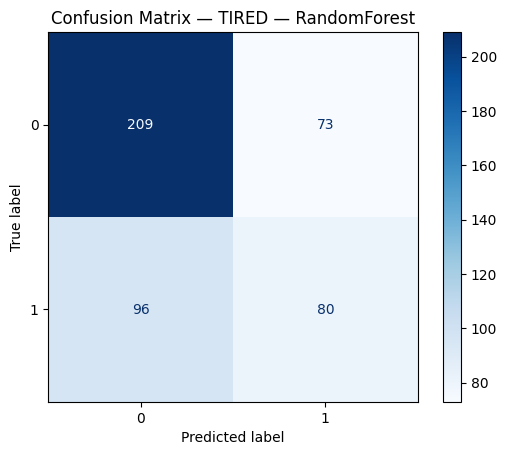

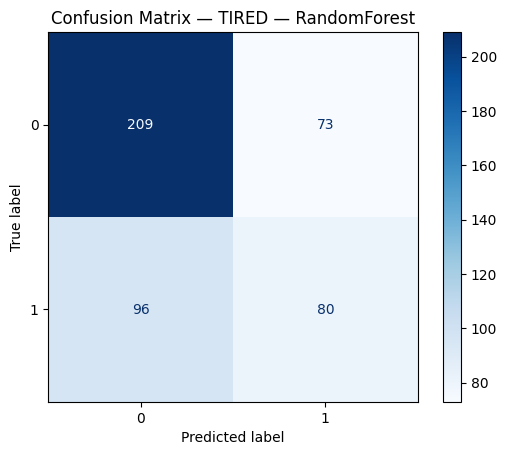

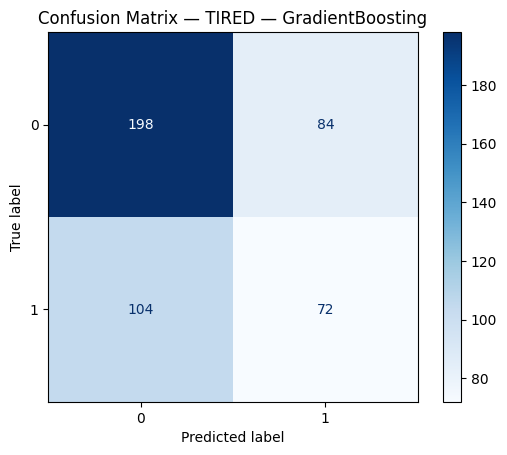

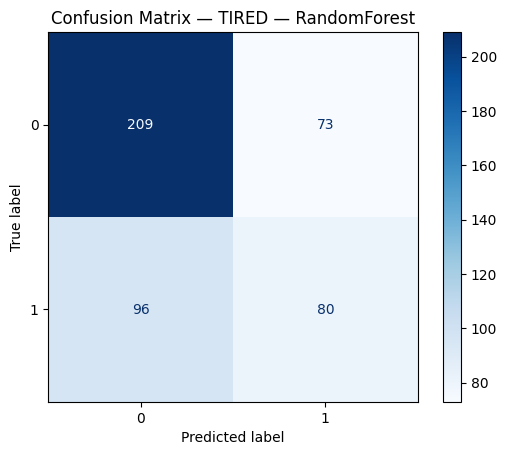

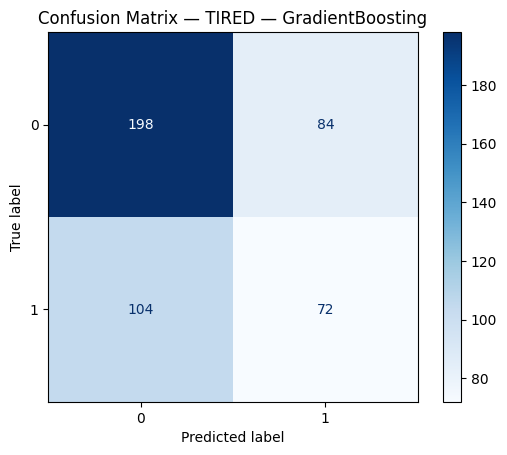

In [ ]:
tired_top5 = combined_results_sorted.head(5)

# Mostra la taula resum dels 5 millors
print(f"\nTop 5 models per a {TARGET} segons Test Accuracy:\n")
display(tired_top5[["Model","Test Accuracy","Test F1 (1)"]])

# Dibuixa la matriu de confusió de cada un
for model in tired_top5["Model"]:
    clf = base_models[model] 
    y_pred = clf.predict(X_test)  
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix — {TARGET} — {model}")
    plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve

# (1) Reserva un 15 % del train com a validació
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)

best_rf = base_models["RandomForest"]
# (2) Reentrena el teu millor model només amb X_tr
best_rf.fit(X_tr, y_tr)

# (3) Probabilitats al set de validació
proba_val = best_rf.predict_proba(X_val)[:, 1]

# (4) Busquem el llindar que maximitzi F1
prec, rec, th = precision_recall_curve(y_val, proba_val)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_thr = th[f1.argmax()]
print(f"llindar òptim ≈ {best_thr:.2f}  —  F1_valid = {f1.max():.3f}")


In [ ]:
f1 = make_scorer(f1_score, pos_label=1)

clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "n_estimators": randint(300, 800),
    "max_depth":    randint(3, 8),
    "learning_rate": uniform(0.01, 0.19),
    "subsample":    uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "min_child_weight": randint(1, 6),
    "gamma": uniform(0, 0.3),
    "scale_pos_weight": [ (y_train==0).sum()/(y_train==1).sum() ]
}

pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", clf)
])

rs_xgb = RandomizedSearchCV(
    pipe, param_dist, n_iter=30, scoring=f1,
    cv=5, n_jobs=-1, random_state=42, refit=True
)

rs_xgb.fit(X_train, y_train,
           **{"classifier__eval_set": [(X_val, y_val)],
              "classifier__early_stopping_rounds": 40,
              "classifier__verbose": 0})